<a href="https://colab.research.google.com/github/kishansheth/BilliardsAssistant/blob/master/BilliardsAssistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Billiards Assistant
####*Kishan Sheth (kps2138@columbia.edu)*
####*COMS W4735 Visual Interfaces to Computers Final Project*

## Overview

For the final project of this course, I take advantage of the fact that I am quarantined in the basement of my friend’s house with a pool table. 

In the following lines of code, I construct a system that, given an image of a game state of 8-ball pool (the most commonly played cue game), suggests the “easiest” shot to take. This is an example of a visual interface because a visual input is captured, there is a reduction of the visual input into data points, and a decision is made based on this reduced data. 

Although I thought of this project independently, simply because I’ve been playing a lot of 8-ball pool, I discovered that many similar computer vision projects have been attempted. However, several of these projects involve either more complex guidance systems, such as AR headsets, or physics calculation that is beyond the scope of this course. Other than algebraic helper functions, I use my own methods and intuition to solve this problem in a manner suitable for COMS W4735.






## Environment

### Pool Table

I utilize an 8-foot pool table with standard dimensions for this project. The length of the playing area is 96 inches, and the width is 48 inches. In order to more easily detect the borders of the playing area (A.K.A the rails, or cushions), I apply a matte red electric tape to each rail.  

### Image Capture

#### Camera

Since several parts of this task require a detailed image, I use a DSLR that produces 4496 x 3000 pixel images. I use a 18mm lens in order to capture the full length of the table, even from a close distance. Unfortantely, this lens slightly distorts the rectangular shape of the table, but I attempt to overcome this as elegantly as possible.  

#### Lighting

I keep lighting as consistent as possible across all input images. Since I am in a basement, no light enters from the outdoors. Before taking each photo, I ensure that the overhead recessed lighting is turned on and I use flash to capture each image. I also keep camera settings consistent to make sure color, depth of field, and exposure is the same across photos. 

Lighting consistency is important because I use color ranges to identify rails and ball pattern. 

#### Angle

For this task, I would ideally capture a birds-eye view of the table, but my camera equipment and the height of the ceiling did not allow for that. Instead, I captured images of the pool table from the side, approximately 45º above the table plane. This made identifying the playing area considerably more difficult. There were several visual distractions surrounding the pool table, such as floor tiling, other furniture/games, and the detail of the pool table frame.  

#### Sample Photo

Here is a sample photo of the pool table and the surrounding environment:

![Sample Photo](https://i.imgur.com/LIQPsp5.jpg)

#### Gameplay Assumptions

The purpose of this assistant is to recommend the "easiest" shot to take. I have defined this to only include *direct shots* in which the cue ball comes into contact with a single target ball, which has a clear path to a pocket. 

I will not include bank shots, in which the rails are touched, or double shots, in which more than one ball is touched.

Therefore, if there is no direct shot available, this program will simply not recommend a shot.

During testing, in which I compare the program's recommended shot to the users' recommended shots, I asked users to only recommend direct shots in order to stay consistent with the program.

### Development

I use Python3 in Google Colab for all portions of this task. The main libraries I use are NumPy and OpenCV. 

In [0]:
# import packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import random
import math
from statistics import mean

In [66]:
# mount drive for file access
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Interfaces/Billiards/images/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Interfaces/Billiards/images


## Program

### Gathering Dimensions

First, I gather the real dimensions of the pool table in inches and store them as global variables. Next, using a virtual table length (which I arbitrarily choose to be 600, in this case), I determine the dimensions of elements once they are mapped onto a virtual representation of the table.

In [0]:
# billiards table dimensions in inches
TABLE_LENGTH = 92
TABLE_WIDTH = 46
TABLE_FRAME_DEPTH = 3.5

POCKET_DIAMETER = 4
CORNER_OPENING = 5
SIDE_OPENING = 5.5

RAIL_LENGTH_LONG = 40
RAIL_LENGTH_SHORT = 39
RAIL_DEPTH = 2
RAIL_EDGE_TO_CORNER = 3.5
RAIL_FRAME_DEPTH = TABLE_FRAME_DEPTH + RAIL_DEPTH

BALL_DIAMETER = 2.25

# billiards table dimensions in pixels
TABLE_LENGTH_PIX = 600
SCALE = TABLE_LENGTH_PIX / TABLE_LENGTH

TABLE_WIDTH_PIX = int(round(TABLE_WIDTH * SCALE))
TABLE_FRAME_DEPTH_PIX = int(round(TABLE_FRAME_DEPTH * SCALE))

POCKET_DIAMETER_PIX = int(round(POCKET_DIAMETER * SCALE))
CORNER_OPENING_PIX = int(round(CORNER_OPENING * SCALE))
SIDE_OPENING_PIX = int(round(SIDE_OPENING * SCALE))

RAIL_LENGTH_LONG_PIX = int(round(RAIL_LENGTH_LONG * SCALE))
RAIL_LENGTH_SHORT_PIX = int(round(RAIL_LENGTH_SHORT * SCALE))
RAIL_DEPTH_PIX = int(round(RAIL_DEPTH * SCALE))
RAIL_EDGE_TO_CORNER_PIX = int(round(RAIL_EDGE_TO_CORNER * SCALE))
RAIL_FRAME_DEPTH_PIX = int(round(RAIL_FRAME_DEPTH * SCALE))

BALL_DIAMETER_PIX = int(round(BALL_DIAMETER * SCALE))

### Helper Functions

Below are several helper functions used throughout the program to aid in algebraic and geometric calculations. 

#### `findIntersection()`

In [0]:
# given two line segments, this function returns their intersection, if it exists
# adapted from https://stackoverflow.com/questions/3838329/how-can-i-check-if-two-segments-intersect 
def findIntersection(L1, L2):

  # gather points of segments
  X1 = L1[0][0]
  Y1 = L1[0][1]
  X2 = L1[1][0]
  Y2 = L1[1][1]
  X3 = L2[0][0]
  Y3 = L2[0][1]
  X4 = L2[1][0]
  Y4 = L2[1][1]

  # get slopes and intercepts of segments
  A1 = (Y1-Y2)/(X1-X2)  
  A2 = (Y3-Y4)/(X3-X4)
  b1 = Y1-A1*X1
  b2 = Y3-A2*X3

  # if lines parallel, no intersection
  if (A1 == A2): 
    return None
  
  # calculate intersection point
  Xa = (b2 - b1) / (A1 - A2)
  Ya = A2 * Xa + b2

  # if intersection point is in range of segments, return intersection
  if ( (Xa < max( min(X1,X2), min(X3,X4) )) or
     (Xa > min( max(X1,X2), max(X3,X4) )) ):
    return None
  else:
    return (int(Xa), int(Ya))



#### `getVector()`

In [0]:
# given two points (a line segment), this function returns its vector representation
def getVector(point1, point2):
  return np.array([point2[0]-point1[0], point2[1]-point1[1]])

#### `findBumpers()`

When a pool ball rolls across the table, it's path can be represented as a line segment drawn from the center of the ball's starting point, to the center of the ball's contact or resting point. 

![alt text](https://)

Of course, the ball collides with any obstructions in this path, whether that be a rail or another ball. However, it also collides with anything within the ball's radius to either side of this path.

![alt text](https://)

The function `findBumpers()` finds these "bumpers" to either side of a ball's path to aid with collision detection.  

In [0]:
# given a ball path (a line segment), this function finds the left and right bounds of the path
def findBumpers(point1, point2):
  path_vector = getVector(point1, point2)
  norm = math.sqrt(path_vector[0] ** 2 + path_vector[1] ** 2)
  direction = np.array([path_vector[0] / norm, path_vector[1] / norm])
  perp_unit = direction.dot(np.array([[0,-1],[1,0]]))
  perp_vector = perp_unit * BALL_RADIUS_PIX

  bumper1 = [point1 + perp_vector, point2 + perp_vector]
  bumper2 = [point1 - perp_vector, point2 - perp_vector]

  return [bumper1, bumper2]

#### `getGuideBall()`

![Ball collision diagram](https://www.real-world-physics-problems.com/images/physics_billiards_1.png)

*diagram from www.real-world-physics-problems.com/physics-of-billiards.html*

In order to get a target ball (B) to travel in a specific direction (V2B), it must be struck at a contact point (CP) located on the perimeter of the ball in the opposite direction of V2B. 

Therefore, it is helpful to picture a "guide ball" – in essence, the cue ball's position during contact – when determining the necessary path of the cue ball. 

`getGuideBall()` determines the location of this imaginary guide ball. 

In [0]:
# given a target ball's position and a target pocket, this function returns the position of a "guide ball"
def getGuideBall(target_ball, target_pocket):

  # find path vector from target ball to target pocket
  path_vector = getVector(target_ball, target_pocket)

  # find unit vector (only direction matters in this case)
  norm = math.sqrt(path_vector[0] ** 2 + path_vector[1] ** 2)
  direction = np.array([path_vector[0] / norm, path_vector[1] / norm])

  # return a point in the opposite direction of the unit vector, a ball's diameter away from the target ball
  return target_ball - BALL_DIAMETER_PIX*direction

### Program Code

Below are code snippets and functions that help perform various portions of the task at hand.

#### Image Import

First, I import the image and get its shape.

In [0]:
# import image
img = cv2.imread('rails.jpg')
orig_h = img.shape[0]
orig_w = img.shape[1]

#### Locating the Table

Given the amount of background noise in my images, locating the playing table proved a relatively difficult task. Originally, I attempted to use OpenCV functions such as `cv2.houghLinesP()` and edge detectors such as `cv2.canny()` to locate table and rail edges. However, lens distortion and background noise gave rise to several false positives and negatives.

Eventually, I decided to apply red tape to the rails of the pool table, so I could use a red color mask to isolate the tape and thus determine the playing area. 

**Isolating the color red**

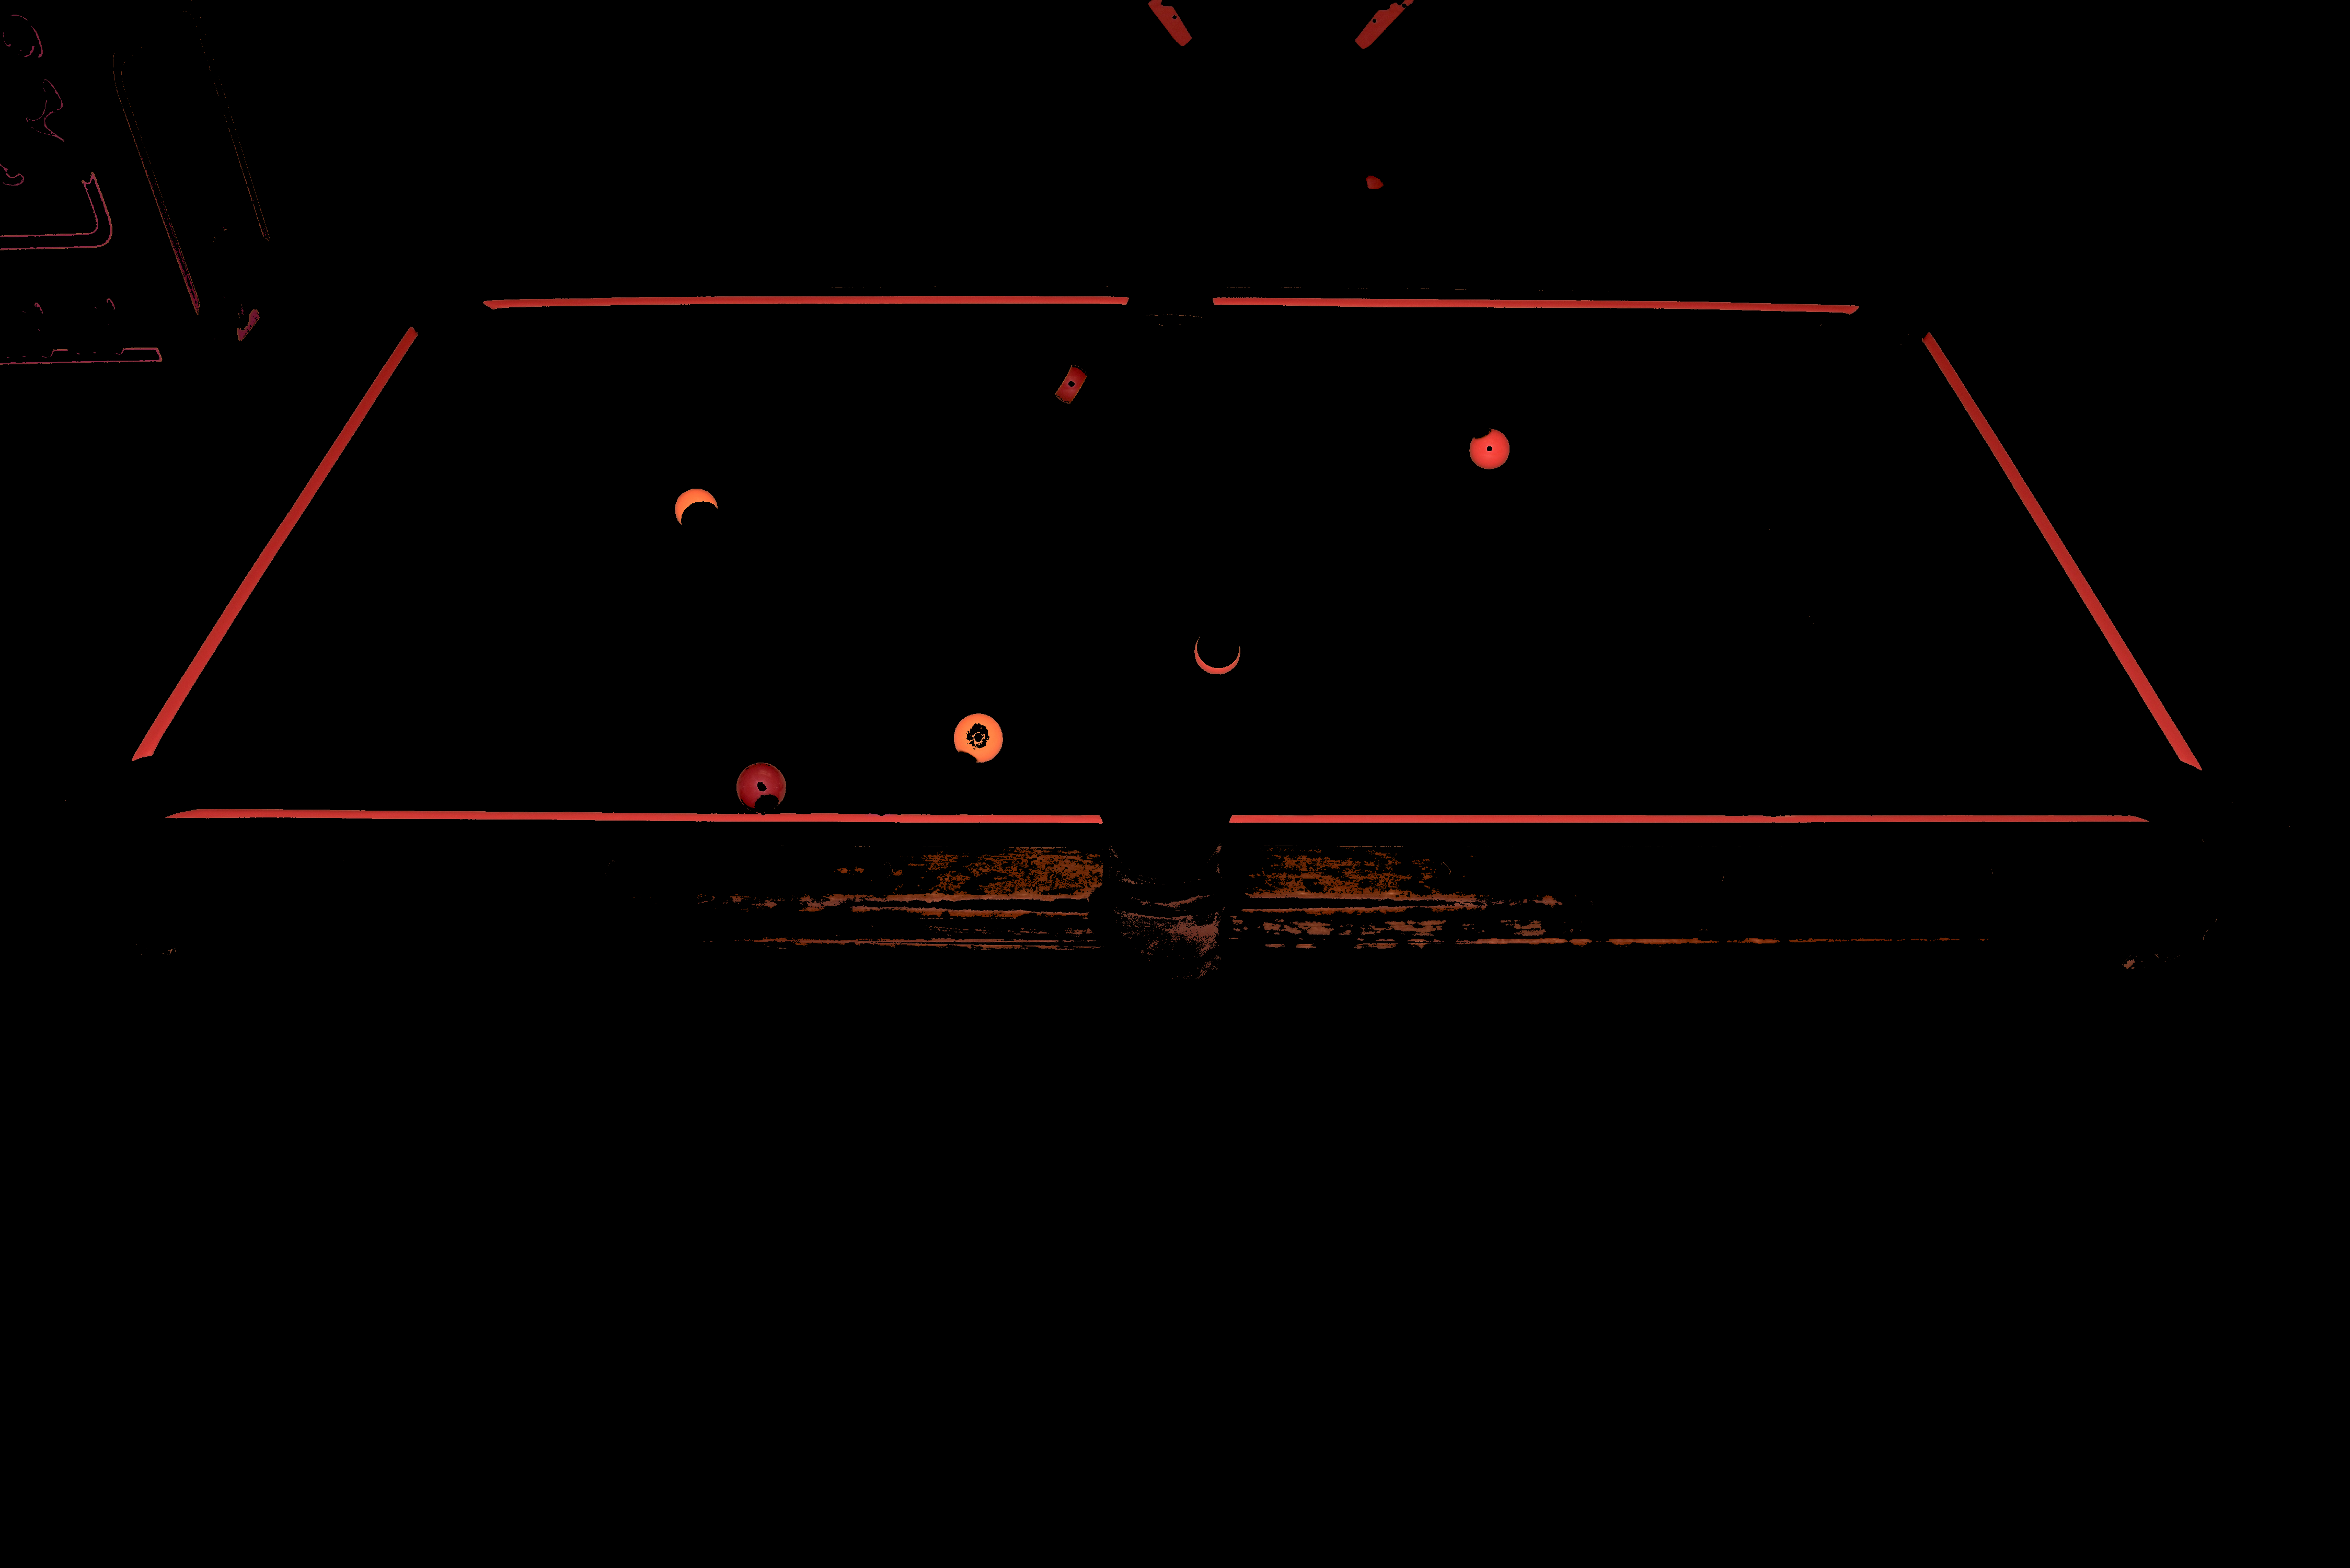

In [91]:
# convert image to HSV color mode (easier for working with color ranges)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# define red HSV range
# in HSV, red "wraps around" hue value, spanning H values of 0-10 and 170-180
lower_red1 = np.array([0,150,100])
upper_red1 = np.array([10,255,255])
lower_red2 = np.array([170,150,100])
upper_red2 = np.array([180,255,255])

# isolate red using color masks
lower_mask = cv2.inRange(hsv, lower_red1, upper_red1)
upper_mask = cv2.inRange(hsv, lower_red2, upper_red2)
full_mask = cv2.bitwise_or(lower_mask, upper_mask)
res = cv2.bitwise_and(img,img, mask= full_mask)

cv2_imshow(res)

**Creating contours to locate rails**

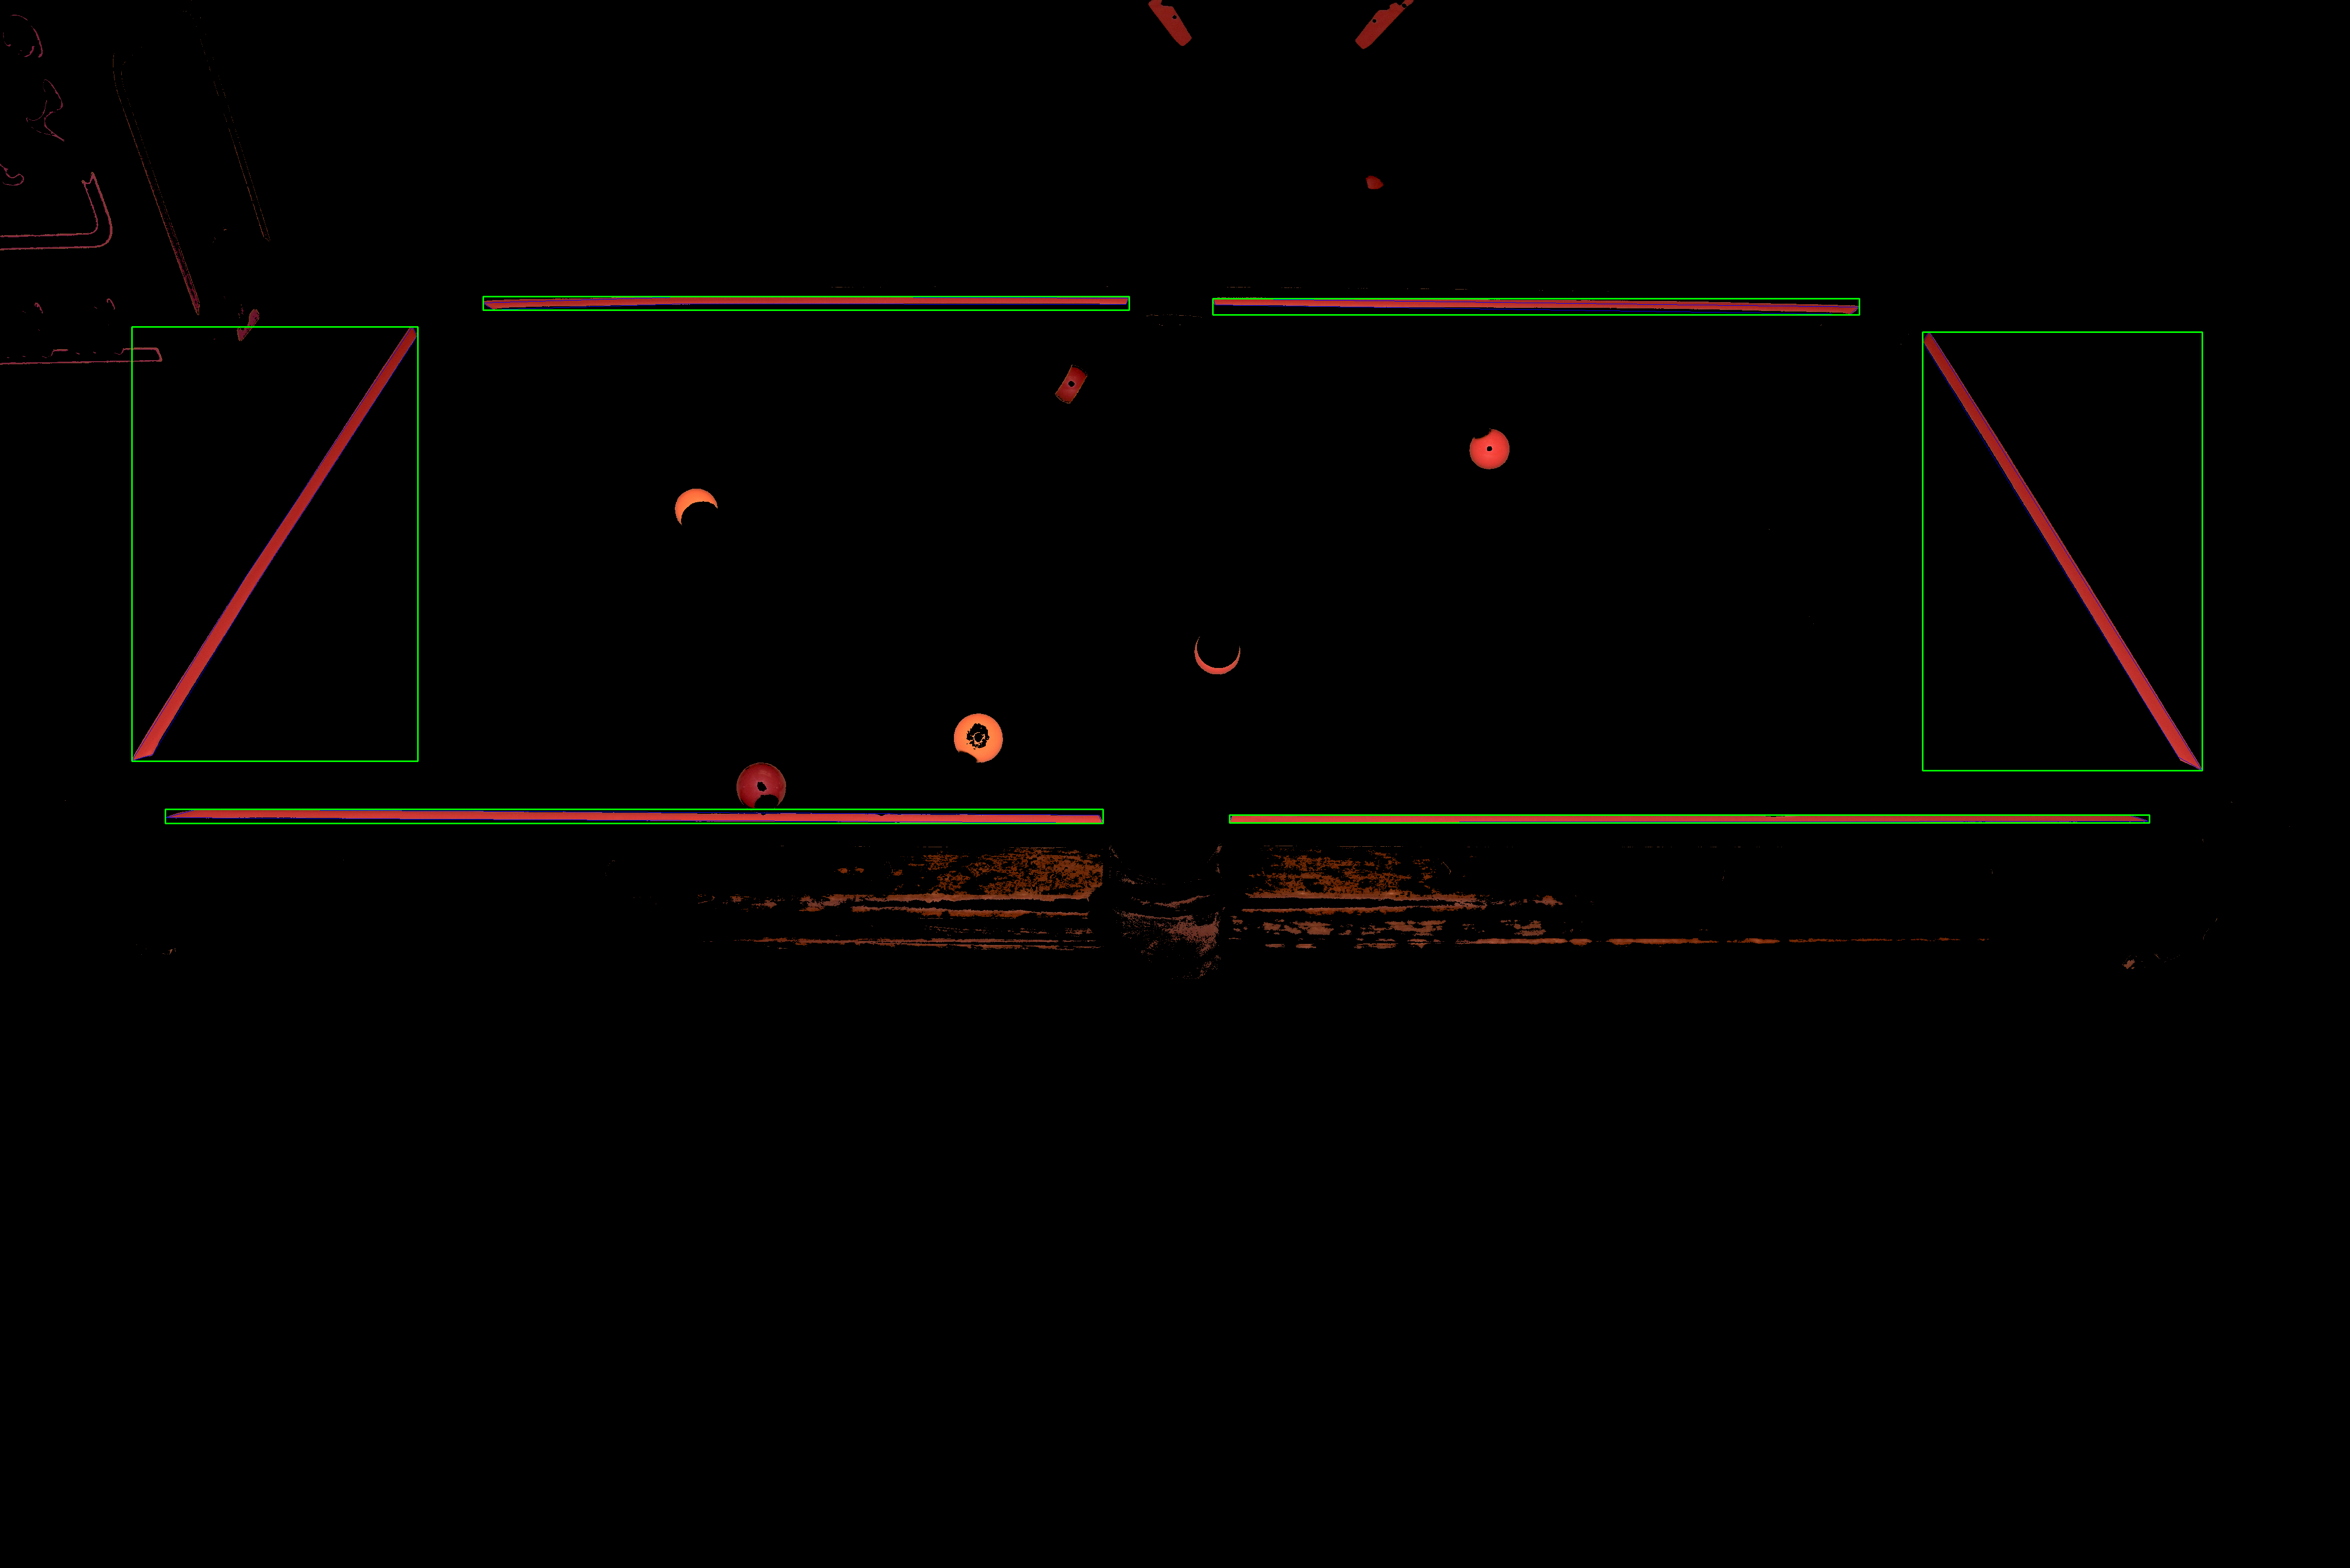

In [92]:
# find contours in red mask
contours, heirarchy = cv2.findContours(full_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

rail_tapes = []

# locate contours with largest perimeters
for contour in contours:
  
  # approximate contour
  contour_approx = cv2.approxPolyDP(contour, 0.003*cv2.arcLength(contour, True), True)

  # get contour bounding rectange
  x,y,w,h = cv2.boundingRect(contour_approx)

  # if perimeter is sufficiently large, contour is a rail
  if w+h > 0.25*orig_w:
    rail_tapes.append((contour_approx, x, y, w, h))
    cv2.drawContours(res, [contour_approx], 0, (255, 0, 0), 0)
    cv2.rectangle(res,(x,y),(x+w,y+h),(0,255,0),2)

cv2_imshow(res)

-0.013793712911285668
0.013892112684323284
-1.5770091843161127
1.6145429330324612
0.00597702821762571
-0.00027746874381610355
(-0.013793712911285668, 605.7453907300279)
(0.013892112684323284, 569.7702985723699)
(-1.5770091843161127, 1885.030338268574)
(1.6145429330324612, -5303.2889076933925)
(0.00597702821762571, 1546.1112590832304)
(-0.00027746874381610355, 1559.6526064854554)
(4.919988651880779e-05, 587.7578446511989)
(0.002849779736904803, 1552.881932784343)
[(0, 587.7578446511989), (4496, 587.9790473409874)]
[(0, 1552.881932784343), (4496, 1565.694542481467)]
[(1195.319822494273, 0), (-707.0153254782373, 3000)]
[(3284.6998362147406, 0), (5142.810846223841, 3000)]
(822, 587)
(3648, 587)
(210, 1553)
(4254, 1565)
[[[ 210 1553]]

 [[4254 1565]]

 [[3648  587]]

 [[ 822  587]]]


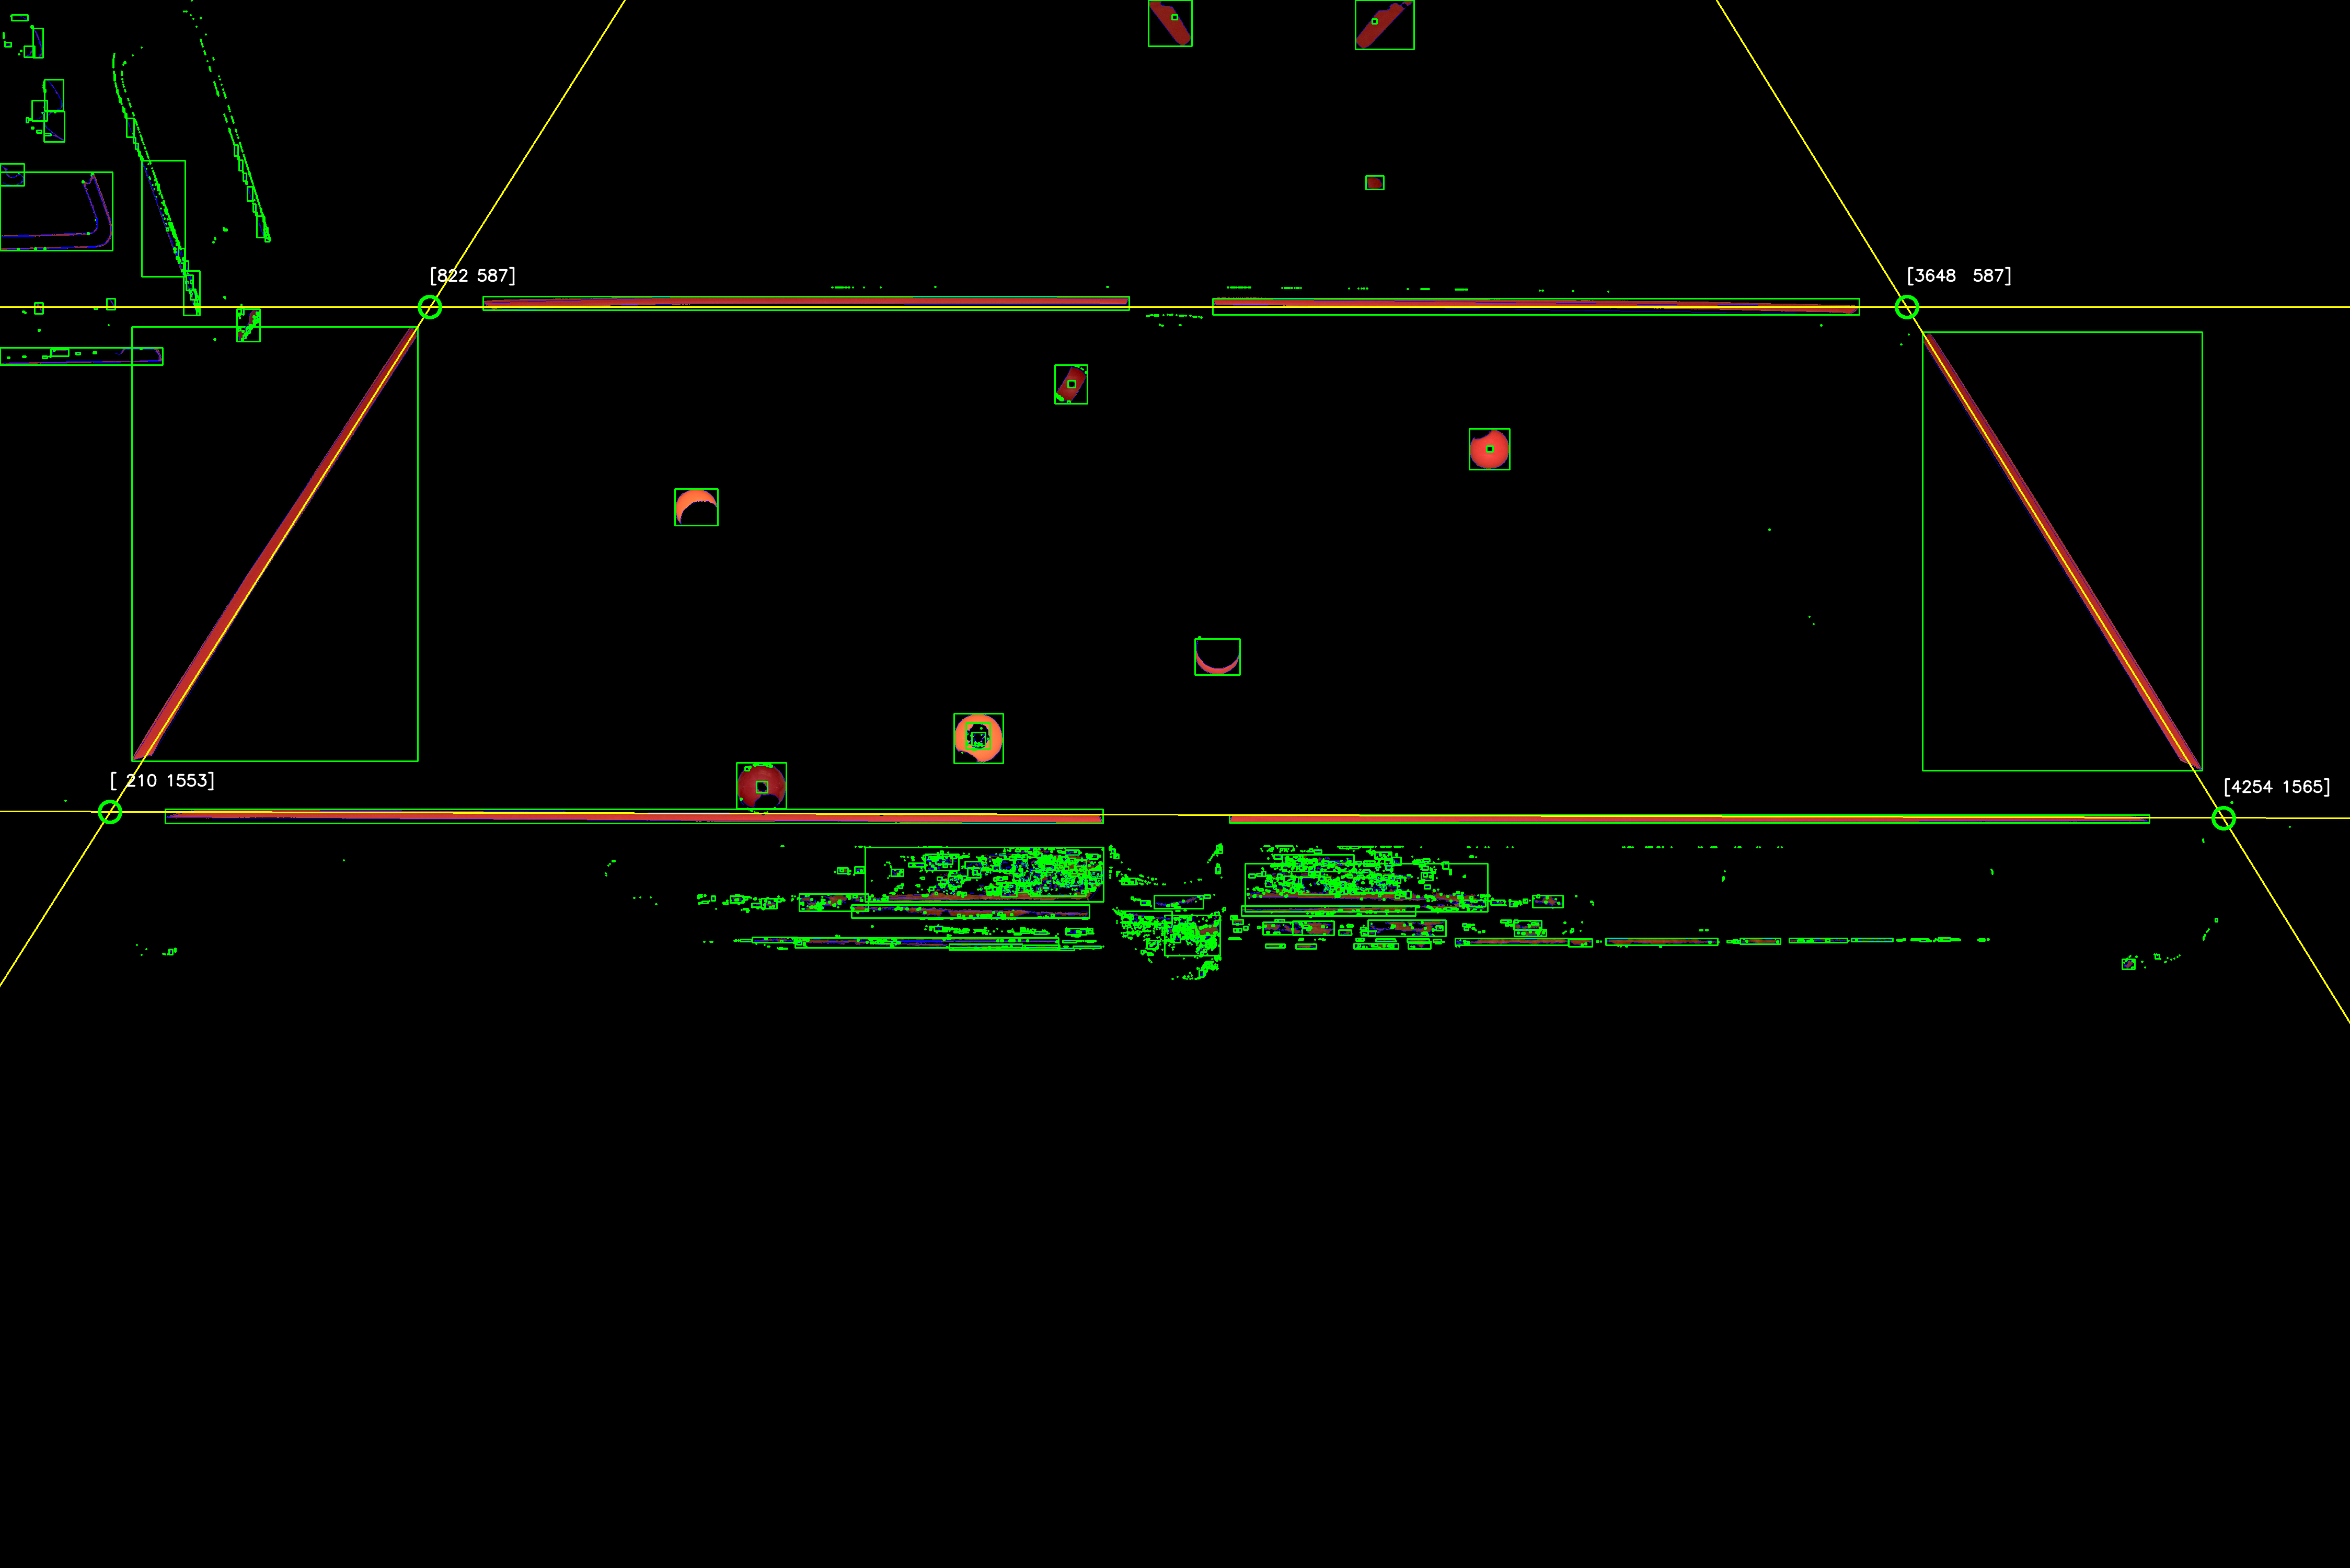

In [73]:
# get rail tape types
# 0 = top
# 1 = right
# 2 = bottom
# 3 = left
rail_tapes_sorted = sorted(rail_tapes, key=lambda x: x[2])
# print(rail_tapes_sorted)

if rail_tapes_sorted[0][1] < rail_tapes_sorted[1][1]:
  top_left_rail = rail_tapes_sorted[0]
  top_right_rail = rail_tapes_sorted[1]
else:
  top_left_rail = rail_tapes_sorted[1]
  top_right_rail = rail_tapes_sorted[0]

if rail_tapes_sorted[2][1] < rail_tapes_sorted[3][1]:
  left_rail = rail_tapes_sorted[2]
  right_rail = rail_tapes_sorted[3]
else:
  left_rail = rail_tapes_sorted[3]
  right_rail = rail_tapes_sorted[2]

if rail_tapes_sorted[4][1] < rail_tapes_sorted[5][1]:
  bottom_left_rail = rail_tapes_sorted[4]
  bottom_right_rail = rail_tapes_sorted[5]
else:
  bottom_left_rail = rail_tapes_sorted[5]
  bottom_right_rail = rail_tapes_sorted[4]


def findLongEdgeLine(contour_info, rail_position):
  contour = contour_info[0]
  # print("ConTOUR: ", contour)

  # only use long edges of rails
  long_edges = []
  for i in range(len(contour)):
    edge = np.array([contour[i], contour[i-1]])
    edge_len = np.linalg.norm(edge[0] - edge[1])
    if edge_len > 100:
      long_edges.append(edge)
    
  # find average slope of long edges
  slope_sum = 0
  for long_edge in long_edges:
    slope_sum += (long_edge[1][0][1] - long_edge[0][0][1]) / (long_edge[1][0][0] - long_edge[0][0][0])
  slope_avg = slope_sum / len(long_edges)
  print(slope_avg)

  # find inner point on rail line (depends on rail position)
  
  # top rail
  if rail_position == 0:
    point = (contour_info[1], contour_info[2] + contour_info[4])
    intercept = point[1] - (slope_avg * point[0])
  
  # right rail
  if rail_position == 1:
    point = (contour_info[1], contour_info[2])
    intercept = point[1] - (slope_avg * point[0])

  # bottom rail
  if rail_position == 2:
    point = (contour_info[1], contour_info[2])
    intercept = point[1] - (slope_avg * point[0])
  
  # left rail
  if rail_position == 3:
    point = (contour_info[1] + contour_info[3], contour_info[2])
    intercept = point[1] - (slope_avg * point[0])

  return (slope_avg, intercept)



top_left_rail_line = findLongEdgeLine(top_left_rail, 0)
top_right_rail_line = findLongEdgeLine(top_right_rail, 0)
left_rail_line = findLongEdgeLine(left_rail, 3)
right_rail_line = findLongEdgeLine(right_rail, 1)
bottom_left_rail_line = findLongEdgeLine(bottom_left_rail, 2)
bottom_right_rail_line = findLongEdgeLine(bottom_right_rail, 2)

print(top_left_rail_line)
print(top_right_rail_line)
print(left_rail_line)
print(right_rail_line)
print(bottom_left_rail_line)
print(bottom_right_rail_line)

top_rail_line = (mean([top_left_rail_line[0], top_right_rail_line[0]]), mean([top_left_rail_line[1], top_right_rail_line[1]]))
bottom_rail_line = (mean([bottom_left_rail_line[0], bottom_right_rail_line[0]]), mean([bottom_left_rail_line[1], bottom_right_rail_line[1]]))

print(top_rail_line)
print(bottom_rail_line)

top_rail_segment = [(0, top_rail_line[0]*0+top_rail_line[1]), (orig_w, top_rail_line[0]*orig_w+top_rail_line[1])]
bottom_rail_segment = [(0, bottom_rail_line[0]*0+bottom_rail_line[1]), (orig_w, bottom_rail_line[0]*orig_w+bottom_rail_line[1])]
left_rail_segment = [((0-left_rail_line[1])/left_rail_line[0], 0), ((orig_h-left_rail_line[1])/left_rail_line[0], orig_h)]
right_rail_segment = [((0-right_rail_line[1])/right_rail_line[0], 0), ((orig_h-right_rail_line[1])/right_rail_line[0], orig_h)]

print(top_rail_segment)
print(bottom_rail_segment)
print(left_rail_segment)
print(right_rail_segment)

cv2.line(res, (int(top_rail_segment[0][0]), int(top_rail_segment[0][1])), (int(top_rail_segment[1][0]), int(top_rail_segment[1][1])), (0, 255, 255), 2)
cv2.line(res, (int(left_rail_segment[0][0]), int(left_rail_segment[0][1])), (int(left_rail_segment[1][0]), int(left_rail_segment[1][1])), (0, 255, 255), 2)
cv2.line(res, (int(right_rail_segment[0][0]), int(right_rail_segment[0][1])), (int(right_rail_segment[1][0]), int(right_rail_segment[1][1])), (0, 255, 255), 2)
cv2.line(res, (int(bottom_rail_segment[0][0]), int(bottom_rail_segment[0][1])), (int(bottom_rail_segment[1][0]), int(bottom_rail_segment[1][1])), (0, 255, 255), 2)

top_left_point = findIntersection(top_rail_segment, left_rail_segment)
top_right_point = findIntersection(top_rail_segment, right_rail_segment)
bottom_left_point = findIntersection(bottom_rail_segment, left_rail_segment)
bottom_right_point = findIntersection(bottom_rail_segment, right_rail_segment)

print(top_left_point)
print(top_right_point)
print(bottom_left_point)
print(bottom_right_point)

contour_approx = np.array([[bottom_left_point], [bottom_right_point], [top_right_point], [top_left_point]])

for point in contour_approx:
  cv2.circle(res, (point[0][0], point[0][1]), 20, (0, 255, 0), thickness=5)
  cv2.putText(res, str(point[0]), (point[0][0], point[0][1] - 50), cv2.FONT_HERSHEY_SIMPLEX,  
                      1, (255, 255, 255), 2, cv2.LINE_AA)

cv2_imshow(res)

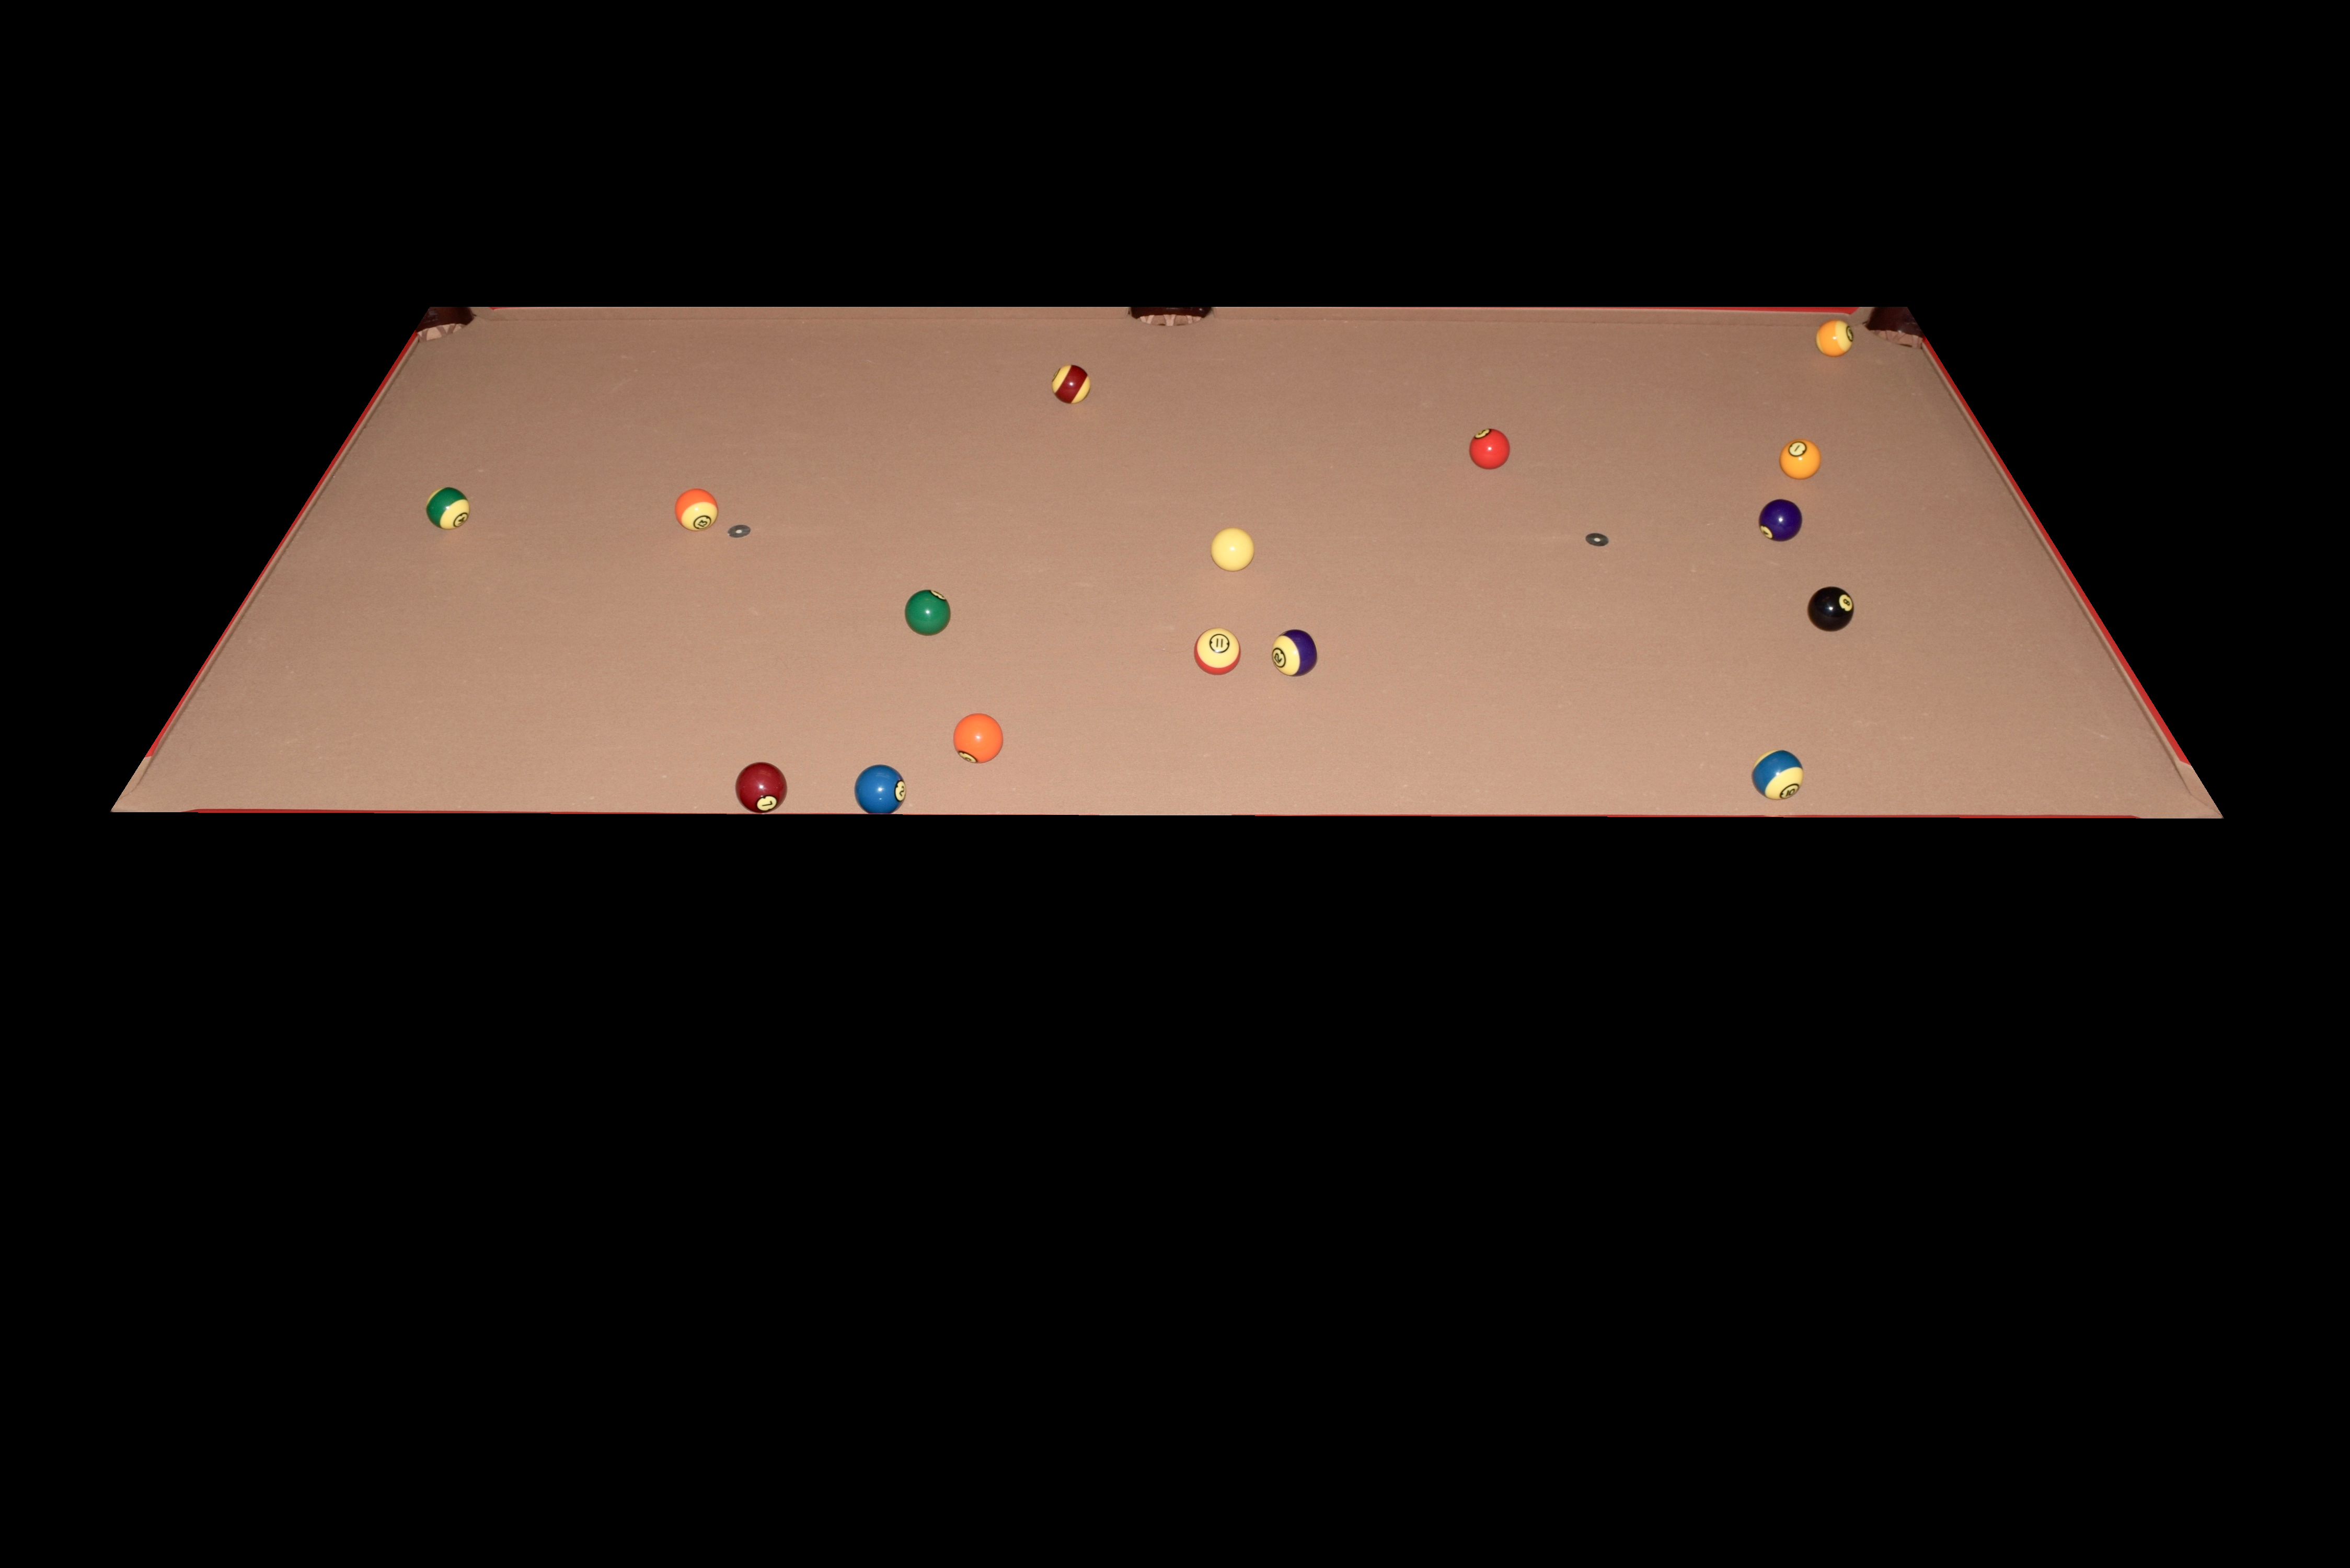

In [74]:
# show only playing table
mask = np.zeros((orig_h,orig_w), np.uint8)
cv2.fillPoly(mask, pts =[contour_approx], color=(255,255,255))

masked_img = cv2.bitwise_and(img, img, mask=mask)

cv2_imshow(masked_img)

In [0]:
# locate balls (https://www.pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/)
gray = cv2.cvtColor(masked_img,cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(gray,
                           cv2.HOUGH_GRADIENT,
                           1,
                           100,
                           param1=100,
                           param2=30,
                           minRadius=10,
                           maxRadius=80)

ball_indicator_img = masked_img.copy()

if circles is not None:
  circles = np.round(circles[0, :]).astype("int")
  for (x, y, r) in circles:
    cv2.circle(ball_indicator_img, (x, y), r, (0, 255, 0), 4)
    cv2.rectangle(ball_indicator_img, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)


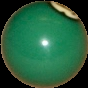

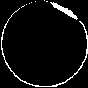

0.06757508430864564


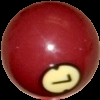

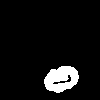

0.08352451413462668


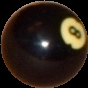

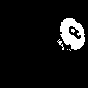

0.08878478230333005


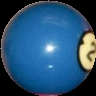

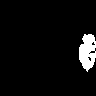

0.06396591896835724


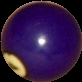

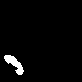

0.03313755507564745


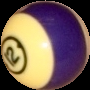

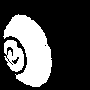

0.3752126905287449


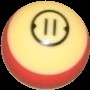

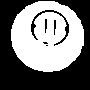

0.6051817589173305


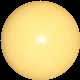

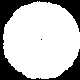

0.9463750803601826


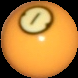

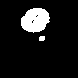

0.11886917511662927


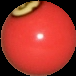

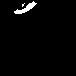

0.024247983019540842


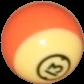

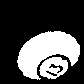

0.3796621318201222


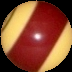

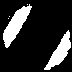

0.22915364491471968


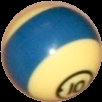

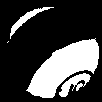

0.33666685770534727


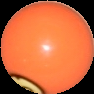

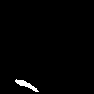

0.015274263438425447


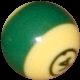

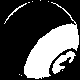

0.38296658181487314


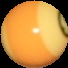

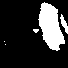

0.24726840639536682


In [76]:
# ball classification

# ivory color
lower_ivory = np.array([20, 10, 0])
upper_ivory = np.array([30, 150, 255])

# threshold to classify ball as stripe, solid, cue
CUE_MIN_THRESH = 0.85
STRIPE_MIN_THRESH = 0.15

mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
mask3 = cv2.bitwise_or(mask1, mask2)
res = cv2.bitwise_and(img,img, mask= mask3)

balls = []

for (x, y, r) in circles:
  mask_canvas = np.zeros((r*2, r*2), np.uint8)
  cv2.circle(mask_canvas, (r, r), r, (255, 255, 255), thickness=-1)
  ball_slice = masked_img[y-r:y+r,x-r:x+r]
  isolated_ball = cv2.bitwise_and(ball_slice, ball_slice, mask=mask_canvas)
  cv2_imshow(isolated_ball)

  # mask that isolates ivory ball color
  ivory_hsv = cv2.cvtColor(isolated_ball, cv2.COLOR_BGR2HSV)
  ivory_mask = cv2.inRange(ivory_hsv, lower_ivory, upper_ivory)
  ivory_res = cv2.bitwise_and(isolated_ball, isolated_ball, mask=ivory_mask)
  cv2_imshow(ivory_mask)

  # percent of ball filled by ivory color
  ivory_percent = np.count_nonzero(ivory_mask)/(np.pi*(r**2))
  print(ivory_percent)

  pattern = ''

  if ivory_percent > CUE_MIN_THRESH:
    pattern = 'cue'
  elif ivory_percent > STRIPE_MIN_THRESH:
    pattern = 'stripe'
  else:
    pattern = 'solid'
  
  balls.append((x, y, r, pattern)) 

  cv2.putText(ball_indicator_img, pattern, (x, y - 60), cv2.FONT_HERSHEY_SIMPLEX,  
                      1, (0, 0, 0), 2, cv2.LINE_AA)
  
# cv2_imshow(ball_indicator_img)

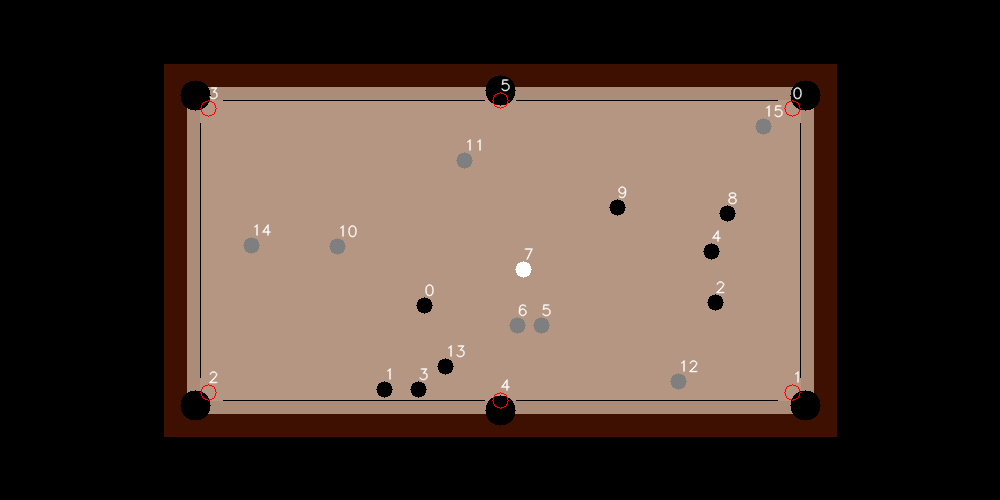

In [77]:
# find corners
corners = contour_approx

corners_old = []
for corner in corners:
	corners_old.append([corner[0][0], corner[0][1]])
corners_new = [[200, 100], [800, 100], [200, 400], [800, 400]]

old_rect = np.zeros((4, 2), dtype = "float32")
old_rect[0] = corners_old[3]
old_rect[1] = corners_old[0]
old_rect[2] = corners_old[2]
old_rect[3] = corners_old[1]

new_rect = np.zeros((4, 2), dtype = "float32")
new_rect[0] = corners_new[0]
new_rect[1] = corners_new[2]
new_rect[2] = corners_new[1]
new_rect[3] = corners_new[3]

# compute homography
H = cv2.findHomography(old_rect, new_rect)

# apply homography to photo
im_warped = cv2.warpPerspective(ball_indicator_img, H[0], (1000, 500))

# create table

cv2.fillPoly(im_warped, pts = [np.array([
	[800+RAIL_FRAME_DEPTH_PIX, 100-RAIL_FRAME_DEPTH_PIX], 
	[800+RAIL_FRAME_DEPTH_PIX, 400+RAIL_FRAME_DEPTH_PIX], 
	[200-RAIL_FRAME_DEPTH_PIX, 400+RAIL_FRAME_DEPTH_PIX], 
	[200-RAIL_FRAME_DEPTH_PIX, 100-RAIL_FRAME_DEPTH_PIX]])], color=(2,16,62))
cv2.fillPoly(im_warped, pts = [np.array([
	[800+RAIL_DEPTH_PIX, 100-RAIL_DEPTH_PIX], 
	[800+RAIL_DEPTH_PIX, 400+RAIL_DEPTH_PIX], 
	[200-RAIL_DEPTH_PIX, 400+RAIL_DEPTH_PIX], 
	[200-RAIL_DEPTH_PIX, 100-RAIL_DEPTH_PIX]])], color=(120,140,170))
cv2.fillPoly(im_warped, pts = [np.array([corners_new[1], corners_new[3], corners_new[2], corners_new[0]])], color=(130, 150, 180))

# create pockets
pockets = [(800+5, 100-5), (800+5, 400+5), (200-5, 400+5), (200-5, 100-5), (500, 400+10), (500, 100-10)]
for pocket in pockets:
	cv2.circle(im_warped, pocket, 15, (0, 0, 0), thickness=-1)

# create rails
rails = [	[(200+RAIL_EDGE_TO_CORNER_PIX,100),(200+RAIL_EDGE_TO_CORNER_PIX+RAIL_LENGTH_LONG_PIX, 100)],
         	[(800-RAIL_EDGE_TO_CORNER_PIX,100),(800-RAIL_EDGE_TO_CORNER_PIX-RAIL_LENGTH_LONG_PIX, 100)],
					[(200+RAIL_EDGE_TO_CORNER_PIX,400),(200+RAIL_EDGE_TO_CORNER_PIX+RAIL_LENGTH_LONG_PIX, 400)],
					[(800-RAIL_EDGE_TO_CORNER_PIX,400),(800-RAIL_EDGE_TO_CORNER_PIX-RAIL_LENGTH_LONG_PIX, 400)],
					[(200,100+RAIL_EDGE_TO_CORNER_PIX),(200, 400-RAIL_EDGE_TO_CORNER_PIX)],
					[(800,100+RAIL_EDGE_TO_CORNER_PIX),(800, 400-RAIL_EDGE_TO_CORNER_PIX)] 
				]

for rail in rails:
	cv2.line(im_warped, rail[0], rail[1], (0, 0, 0), 1)

# create target spots
BALL_RADIUS_PIX = BALL_DIAMETER_PIX//2+1
target_spots = [(800-BALL_RADIUS_PIX,100+BALL_RADIUS_PIX), 
                (800-BALL_RADIUS_PIX,400-BALL_RADIUS_PIX), 
								(200+BALL_RADIUS_PIX,400-BALL_RADIUS_PIX), 
								(200+BALL_RADIUS_PIX,100+BALL_RADIUS_PIX), 
								(500,400), 
								(500,100)]

for i in range(len(target_spots)):
	cv2.circle(im_warped, target_spots[i], BALL_DIAMETER_PIX//2+1, (0, 0, 255), thickness=1)
	cv2.putText(im_warped, str(i), (int(target_spots[i][0]) , int(target_spots[i][1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, .5, (255, 255, 255), 1, cv2.LINE_AA)

# apply homography to balls
ball_array = []
for (x, y, r) in circles:
	ball_array.append([[x, y]])
ball_np_array = np.array(ball_array, np.float32)

new_ball_positions = cv2.perspectiveTransform(ball_np_array, H[0])
for i in range(len(new_ball_positions)):
	cv2.putText(im_warped, str(i), (int(new_ball_positions[i][0][0]), int(new_ball_positions[i][0][1]) - 10), cv2.FONT_HERSHEY_SIMPLEX,  
                      .5, (255, 255, 255), 1, cv2.LINE_AA)

	color = None

	if balls[i][3] == 'cue':
		color = (255, 255, 255)
	elif balls[i][3] == 'stripe':
		color = (127, 127, 127)
	else:
		color = (0, 0, 0)

	cv2.circle(im_warped, (new_ball_positions[i][0][0], new_ball_positions[i][0][1]), BALL_DIAMETER_PIX//2+1, color, -1)
	# cv2.putText(im_warped, str((new_ball_positions[i][0][0], new_ball_positions[i][0][1])), (int(new_ball_positions[i][0][0]), int(new_ball_positions[i][0][1]) - 5), cv2.FONT_HERSHEY_SIMPLEX,  
  #                     0.25, (255, 255, 255), 1, cv2.LINE_AA)

cv2_imshow(im_warped)

In [0]:
def detectBlocks(bumpers, ball_number):

  for bumper in bumpers:
    V = getVector(bumper[0], bumper[1])
    P1 = bumper[0]
    
    # find blocking balls
    for i in range(len(new_ball_positions)):
      Q = new_ball_positions[i][0]
      r = BALL_RADIUS_PIX

      a = V.dot(V)
      b = 2 * V.dot(P1 - Q)
      c = P1.dot(P1) + Q.dot(Q) - 2 * P1.dot(Q) - r**2

      disc = b**2 - 4 * a * c

      if disc > 0 and not i==ball_number:
        sqrt_disc = math.sqrt(disc)
        t1 = (-b + sqrt_disc) / (2 * a)
        t2 = (-b - sqrt_disc) / (2 * a)

        if (0 <= t1 <= 1 or 0 <= t2 <= 1):
          print("blocked by ", i)
          return True
        # print("blocked by ", i)
        # return True

    # find blocking rails

  return False

def getGuideBall(target_ball, target_pocket):
  path_vector = getVector(target_ball, target_pocket)
  norm = math.sqrt(path_vector[0] ** 2 + path_vector[1] ** 2)
  direction = np.array([path_vector[0] / norm, path_vector[1] / norm])
  return target_ball - BALL_DIAMETER_PIX*direction


[523.1679 269.6096]
blocked by  7
TARGET BLOCKED
blocked by  5
TARGET BLOCKED
CLEAR!
blocked by  10
TARGET BLOCKED
blocked by  0
GUIDE BLOCKED
blocked by  11
TARGET BLOCKED
blocked by  15
TARGET BLOCKED
blocked by  12
TARGET BLOCKED
blocked by  3
GUIDE BLOCKED
blocked by  3
GUIDE BLOCKED
blocked by  3
TARGET BLOCKED
blocked by  11
TARGET BLOCKED
blocked by  2
GUIDE BLOCKED
CLEAR!
blocked by  5
TARGET BLOCKED
blocked by  2
GUIDE BLOCKED
blocked by  2
GUIDE BLOCKED
blocked by  9
TARGET BLOCKED
blocked by  13
TARGET BLOCKED
blocked by  12
TARGET BLOCKED
blocked by  1
TARGET BLOCKED
blocked by  3
GUIDE BLOCKED
blocked by  3
GUIDE BLOCKED
blocked by  13
GUIDE BLOCKED
blocked by  8
TARGET BLOCKED
blocked by  4
GUIDE BLOCKED
blocked by  4
GUIDE BLOCKED
blocked by  4
GUIDE BLOCKED
blocked by  4
GUIDE BLOCKED
blocked by  4
GUIDE BLOCKED
blocked by  15
TARGET BLOCKED
blocked by  5
GUIDE BLOCKED
blocked by  6
TARGET BLOCKED
blocked by  6
TARGET BLOCKED
CLEAR!
blocked by  7
TARGET BLOCKED
blocked 

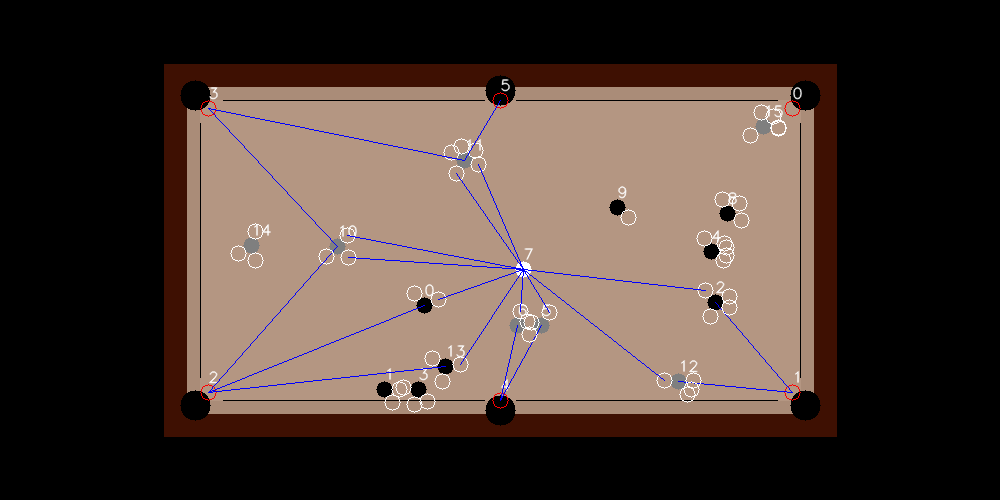

In [87]:
path_img = im_warped.copy()

# get cue ball position
cue_ball_position = None
cue_ball_index = -1
for i in range(len(balls)):
  if balls[i][3] == 'cue':
    cue_ball_position = np.array([new_ball_positions[i][0][0], new_ball_positions[i][0][1]])
    cue_ball_index = i
print(cue_ball_position)

# test target path
shot_options = []

for i in range(len(new_ball_positions)):
  for j in range(len(target_spots)):
    if i != cue_ball_index:
      # print('---')
      # print(i, '->', j)
      test_target = new_ball_positions[i]
      test_target_spot = target_spots[j]

      point1 = np.array([test_target[0][0], test_target[0][1]])
      point2 = np.array([test_target_spot[0], test_target_spot[1]])

      bumpers = findBumpers(point1, point2)

      if detectBlocks(bumpers, i):
        print('TARGET BLOCKED')
        # for bumper in bumpers:
        #   cv2.line(path_img, (int(bumper[0][0]),int(bumper[0][1])), (int(bumper[1][0]),int(bumper[1][1])), (50, 50, 255), 1)
      else:
        # cv2.line(path_img, (int(test_target[0][0]), int(test_target[0][1])), (test_target_spot[0], test_target_spot[1]), (255, 0, 0), 1)
        # for bumper in bumpers:
        #   cv2.line(path_img, (int(bumper[0][0]),int(bumper[0][1])), (int(bumper[1][0]),int(bumper[1][1])), (255, 50, 50), 1)
        guide_ball_position = getGuideBall(point1, point2)
        cv2.circle(path_img, (int(guide_ball_position[0]), int(guide_ball_position[1])), BALL_DIAMETER_PIX//2+1, (255, 255, 255), 1)

        # see if cue ball can make it to guide ball
        bumpers = findBumpers(cue_ball_position, guide_ball_position)

        if detectBlocks(bumpers, cue_ball_index):
          print('GUIDE BLOCKED')
        else:
          print('CLEAR!')

          cue_to_guide = [cue_ball_position, guide_ball_position]
          target_to_pocket = [point1, point2]

          shot_options.append([cue_to_guide, target_to_pocket])

          



          cv2.line(path_img, (int(test_target[0][0]), int(test_target[0][1])), (test_target_spot[0], test_target_spot[1]), (255, 0, 0), 1)
          # cv2.line(path_img, (int(test_target[0][0]), int(test_target[0][1])), (test_target_spot[0], test_target_spot[1]), (255, 0, 0), 1)

          cv2.line(path_img, (int(cue_ball_position[0]), int(cue_ball_position[1])), (int(guide_ball_position[0]), int(guide_ball_position[1])), (255, 0, 0), 1)


print(shot_options)
      

cv2_imshow(path_img)

EASIEST SHOT:  3


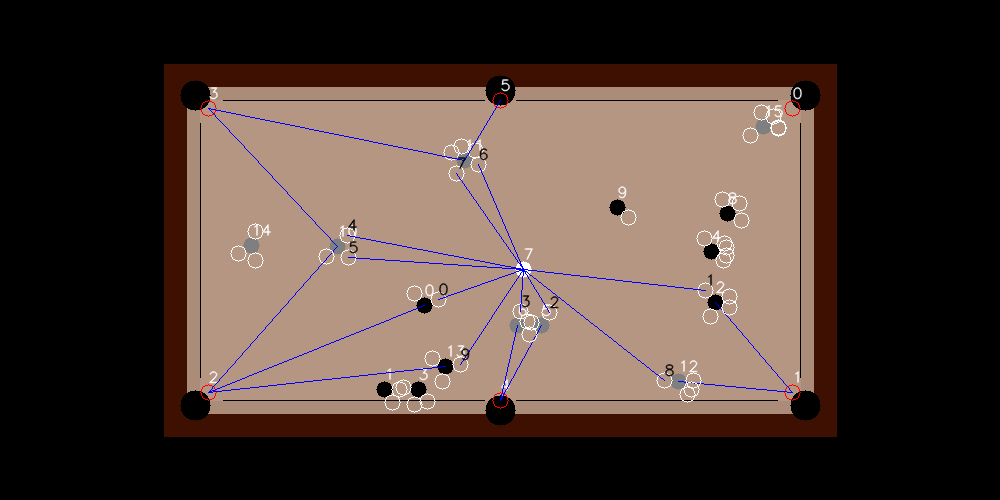

In [88]:
# select easiest shot option
def easiestShot(shot_options):

  easiest_shot_difficulty = 1.0
  easiest_shot_index = 0
  DISTANCE_WEIGHT = 1
  ANGLE_WEIGHT = 2

  for i in range(len(shot_options)):
    shot_option = shot_options[i]

    # assign angle score (between 0 and 1)
    shot_angle = shotAngle(shot_option)
    angle_score = 1-((shot_angle-75)/105)
    

    # cv2.putText(path_img, str(angle_score), (int(shot_option[0][1][0]), int(shot_option[0][1][1]) - 5), cv2.FONT_HERSHEY_SIMPLEX, 
    #             0.25, (0, 0, 0), 1, cv2.LINE_AA)


    # assign distance score (between 0 and 1)
    shot_distance = shotDistance(shot_option)
    longest_distance = TABLE_LENGTH_PIX + TABLE_WIDTH_PIX
    distance_score = shot_distance / longest_distance
    
    # find net score
    net_score = DISTANCE_WEIGHT * distance_score + ANGLE_WEIGHT * angle_score

    cv2.putText(path_img, str(i), (int(shot_option[0][1][0]), int(shot_option[0][1][1]) - 5), cv2.FONT_HERSHEY_SIMPLEX, 
              0.5, (0, 0, 0), 1, cv2.LINE_AA)

    if net_score < easiest_shot_difficulty:
      easiest_shot_difficulty = net_score
      easiest_shot_index = i

  return easiest_shot_index

# angle between cue and target paths
def shotAngle(shot_option):
  # get vectors
  cue_guide_V = getVector(shot_option[0][0], shot_option[0][1])
  target_pocket_V = getVector(shot_option[1][0], shot_option[1][1])

  # get unit vectors
  cue_guide_U = cue_guide_V / np.linalg.norm(cue_guide_V)
  target_pocket_U = target_pocket_V / np.linalg.norm(target_pocket_V)
  dot_product = np.dot(cue_guide_U * -1, target_pocket_U)
  rad_angle = np.arccos(dot_product)
  deg_angle = rad_angle * 180/math.pi

  return deg_angle

# total distance of cue and target paths
def shotDistance(shot_option):
  cue_guide_V = getVector(shot_option[0][0], shot_option[0][1])
  target_pocket_V = getVector(shot_option[1][0], shot_option[1][1])

  cue_guide_dist = np.linalg.norm(cue_guide_V)
  target_pocket_dist = np.linalg.norm(target_pocket_V)

  return cue_guide_dist + target_pocket_dist

easiest_shot = easiestShot(shot_options)
print("EASIEST SHOT: ", easiest_shot)

cv2_imshow(path_img)